<a href="https://colab.research.google.com/github/simplifiedcomputing/weed_detection/blob/main/weed_detection_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weed Detection Inference
Locate medical plants for human and animal health using object detection and classification.

## Install

- FastAI (training loop library)
- IceVision (computer vision framework) -> [forum](https://discord.gg/JDBeZYK)
- MMDetection and Yolo v5 (neural net models)

In [1]:
!pip install openmim -q
!mim install mmcv-full
!mim install mmdet

!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] -U -q
!pip install git+git://github.com/airctic/icedata.git -U -q
!pip install yolov5-icevision -U -q 

installing mmcv-full from wheel.
Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch1.9.0/index.html
     |████████████████████████████████| 25.0 MB 43 kB/s 
     |████████████████████████████████| 185 kB 33.5 MB/s 
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpp4ym1kpt/mmdetection'...
remote: Enumerating objects: 21278, done.
remote: Total 21278 (delta 0), reused 0 (delta 0), pack-reused 21278
Receiving objects: 100% (21278/21278), 24.90 MiB | 27.07 MiB/s, done.
Resolving deltas: 100% (14911/14911), done.
Note: checking out 'd64e719172335fa3d7a757a2a3636bd19e9efb62'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Exampl

In [2]:
# Restart kernel after installation
exit()

## Imports
All of the IceVision components can be easily imported with a single line.


In [1]:
from icevision.all import *
from icevision.models.checkpoint import *

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31


0B [00:00, ?B/s]

#Loading model
If you have saved your model weights with the model metadata, you only need to call model_from_checkpoint(checkpoint_path): No other arguments (model_name, backbone_name, classes, img_size) are needed. All the information is already embedded in the checkpoint file.

In [2]:
checkpoint_path = 'https://simplified-computing.de/weed_detection_split_checkpoint.pth'
checkpoint_and_model = model_from_checkpoint(checkpoint_path)

Use load_from_http loader


Downloading: "https://simplified-computing.de/weed_detection_split_checkpoint.pth" to /root/.cache/torch/hub/checkpoints/weed_detection_split_checkpoint.pth


  0%|          | 0.00/27.0M [00:00<?, ?B/s]

In [3]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.ultralytics.yolov5' from '/usr/local/lib/python3.7/dist-packages/icevision/models/ultralytics/yolov5/__init__.py'>,
 <ClassMap: {'background': 0, 'herbzeitlose': 1}>,
 1920)

In [4]:
model = checkpoint_and_model["model"]

#Transforms

In [5]:
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

#Data

###Single image from URL

In [ ]:
import PIL, requests
def image_from_url(url):
    res = requests.get(url, stream=True)
    img = PIL.Image.open(res.raw)
    return np.array(img)

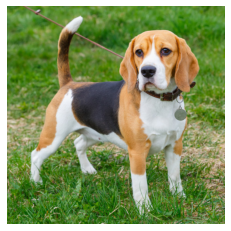

In [ ]:
image_url = "https://petcaramelo.com/wp-content/uploads/2018/06/beagle-cachorro.jpg"
img = image_from_url(image_url)
show_img(img);

In [ ]:
#Create Dataset
infer_ds = Dataset.from_images([img], valid_tfms, class_map=class_map)

### Bunch of images

In [6]:
# download
url = "https://simplified-computing.de/weed_detection_split_testdata.zip"
dest_dir = "weed_detection_split_testdata"
data_dir = icedata.load_data(url, dest_dir)
img_files = get_image_files(data_dir)

  0%|          | 0/9783325 [00:00<?, ?B/s]

In [ ]:
# show sample image from data
img = PIL.Image.open(img_files[4])
img

#### Extract GPS coordinates

not finish yet

In [ ]:
%pip install exif -q
from exif import Image

# load image
img_path = '/home/martin/projekte/herbst/data/image_herbst21_training/DJI_0252.JPG'
img = Image(img_path)
img

# convert to decimal coordinates
def decimal_coords(coords, ref):
 decimal_degrees = coords[0] + coords[1] / 60 + coords[2] / 3600
 if ref == "S" or ref == "W":
     decimal_degrees = -decimal_degrees
 return decimal_degrees

decimal_coords(img.gps_longitude, img.gps_longitude_ref), decimal_coords(img.gps_latitude, img.gps_latitude_ref)

# image dimensions
img.pixel_x_dimension, img.pixel_y_dimension

#### Map coordinates with images

using idmap

#### Split images in smaller pieces

#### Create dataset

In [7]:
imgs_array = [PIL.Image.open(Path(fname)) for fname in img_files]
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

#Predict - All at once

Simply call predict:

In [8]:
preds = model_type.predict(model, infer_ds, keep_images=True, detection_threshold=0.01)

#Predict - In batches
If the memory is not enough to predict everything at once, break it down into smaller batches with infer_dataloader:

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, batch_size=1, shuffle=False)
preds = model_type.predict_from_dl(model=model, infer_dl=infer_dl, keep_images=True)

  0%|          | 0/9 [00:00<?, ?it/s]

#Visualize

Let´s take a look at the bboxes in first image

In [9]:
preds[0].pred.detection.bboxes

[<BBox (xmin:1334.0032958984375, ymin:1575.4737548828125, xmax:1365.3548583984375, ymax:1624.3929443359375)>,
 <BBox (xmin:1383.406005859375, ymin:1541.1202392578125, xmax:1409.405029296875, ymax:1573.9913330078125)>,
 <BBox (xmin:1331.77685546875, ymin:1558.2354736328125, xmax:1354.412353515625, ymax:1600.8631591796875)>]

For visualizing the predictions we can use show_preds:

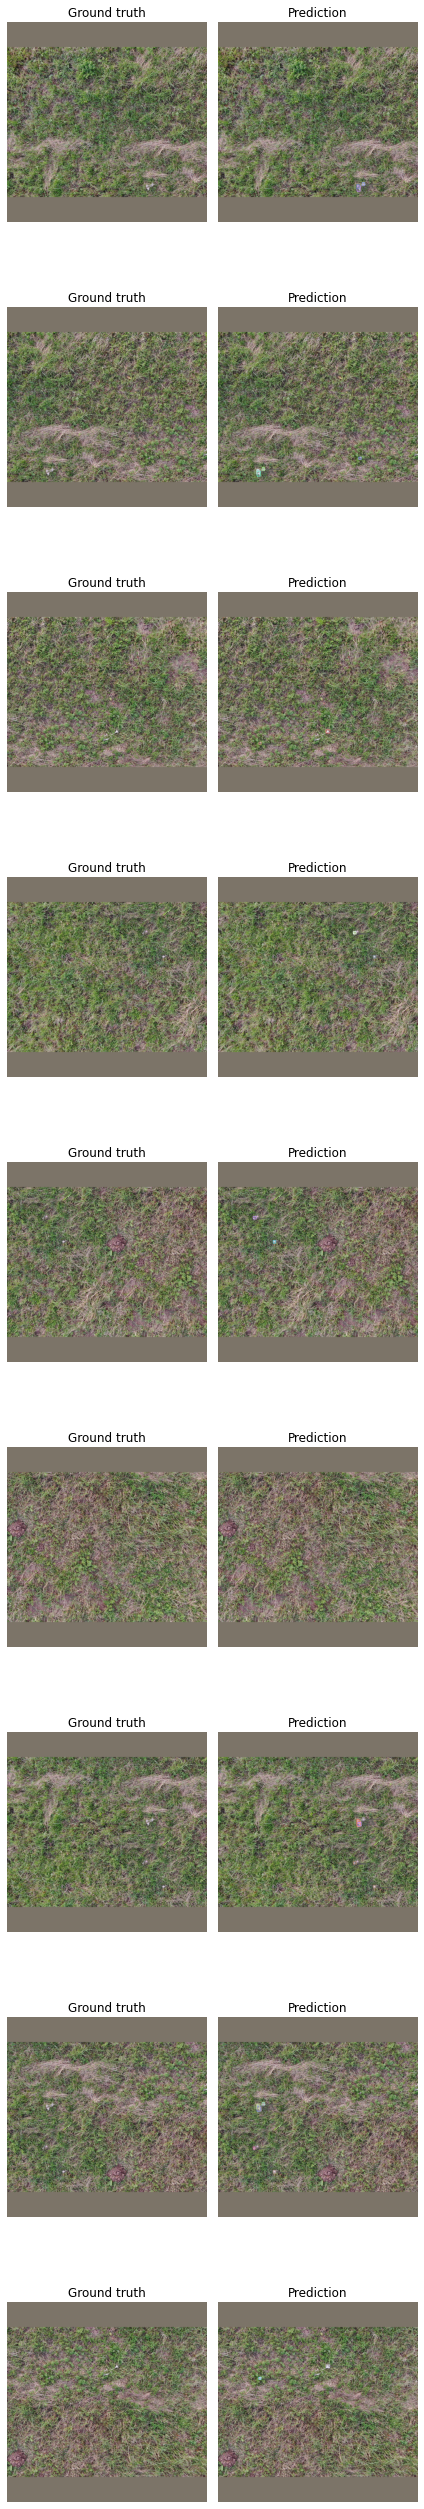

In [10]:
show_preds(preds=preds)
#show_records(preds)

## Localization

Calculate GPS coordinates for detected objects.

In [ ]:
#preds[1].pred.detection.bboxes

## Map

Create Map with detected plants